# Extract data from DrugCentral

Purpose of this notebook is to extract and format drug data for subsequent model annotation.

Currently uses the 2021 TSV file download.

### Citations
Avram S, Wilson TB, Curpan R, Halip L, Borota A, Bora A, Bologa CG, Holmes J, Knockel J, Yang JJ, Oprea TI. DrugCentral 2023 extends human clinical data and integrates veterinary drugs. Nucleic Acids Res. 2023 Jan 6;51(D1):D1276-D1287. doi: 10.1093/nar/gkac1085. PMID: 36484092; PMCID: PMC9825566.

## Setup
### Import packages

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    ROOT_PATH,
    INTERIM_PATH,
    DATABASE_PATH,
    ANNOTATION_PATH,
    GEM_NAME,
    compare_tables,
    visualize_comparison,
    get_annotation_df,
    read_rbc_model,
    split_string,
    build_string,
    explode_column,
)
from rbc_gem_utils.database import DRUGCENTRAL_DB_TAG, DRUGCENTRAL_PATH

## Load RBC-GEM model

In [9]:
model = read_rbc_model(filetype="xml")
model

Name,RBC_GEM
Memory address,14fdeaed0
Number of metabolites,2057
Number of reactions,3030
Number of genes,779
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [12]:
annotation_type = "genes"
annotation_cols = ["uniprot", "drugbank", "drugcentral", "hgnc.symbol"]
mapping_key = "uniprot"

df_model_mappings = (
    get_annotation_df(model.genes, annotation_cols)
    .rename({"id": annotation_type}, axis=1)
    .dropna(subset=[mapping_key])
)
for col in df_model_mappings.columns:
    df_model_mappings = explode_column(df_model_mappings, name=col, sep=";")
df_model_mappings = df_model_mappings.sort_values(annotation_type)

print(df_model_mappings.nunique(dropna=True))
df_model_mappings = df_model_mappings.reset_index(drop=True)

df_model_mappings

genes           779
uniprot         779
drugbank       2244
drugcentral     662
hgnc.symbol     780
dtype: int64


,genes,uniprot,drugbank,drugcentral,hgnc.symbol
0,A4GALT,Q9NPC4,NaN,NaN,A4GALT
1,AARS1,P49588,DB00160,NaN,AARS1
2,AASDHPPT,Q9NRN7,NaN,NaN,AASDHPPT
3,ABCA1,O95477,DB00163,2269,ABCA1
4,ABCA1,O95477,DB00171,2269,ABCA1
...,...,...,...,...,...
96597,YES1,P07947,NaN,NaN,YES1
96598,ZDHHC2,Q9UIJ5,NaN,NaN,ZDHHC2
96599,ZDHHC20,Q5W0Z9,NaN,NaN,ZDHHC20
96600,ZDHHC3,Q9NYG2,NaN,NaN,ZDHHC3


## Set notebook options

In [13]:
database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}{DRUGCENTRAL_PATH}"
annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
# Compare to/Overwrite previous files
compare_figsize = (5, 5)
compare = True
display_nunique = True
overwrite = True
db_tag = DRUGCENTRAL_DB_TAG
df_model_mappings.loc[:, [annotation_type, mapping_key]].drop_duplicates()

,genes,uniprot
0,A4GALT,Q9NPC4
1,AARS1,P49588
2,AASDHPPT,Q9NRN7
3,ABCA1,O95477
9,ABCA7,Q8IZY2
...,...,...
96597,YES1,P07947
96598,ZDHHC2,Q9UIJ5
96599,ZDHHC20,Q5W0Z9
96600,ZDHHC3,Q9NYG2


## Parse DrugCentral information into DataFrame

In [14]:
df_drugcentral = pd.read_csv(
    f"{database_dirpath}/drug.target.interaction.tsv",
    sep="\t",
    dtype=str,
)
# Filter out non-human entries
df_drugcentral = df_drugcentral[
    df_drugcentral["ORGANISM"].str.find("Homo sapiens") != -1
]
df_drugcentral

,DRUG_NAME,STRUCT_ID,TARGET_NAME,TARGET_CLASS,ACCESSION,GENE,SWISSPROT,ACT_VALUE,ACT_UNIT,ACT_TYPE,ACT_COMMENT,ACT_SOURCE,RELATION,MOA,MOA_SOURCE,ACT_SOURCE_URL,MOA_SOURCE_URL,ACTION_TYPE,TDL,ORGANISM
0,levobupivacaine,4,Potassium voltage-gated channel subfamily H me...,Ion channel,Q12809,KCNH2,KCNH2_HUMAN,4.89,NaN,IC50,Inhibition of wild-type human ERG channel expr...,CHEMBL,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
1,levobupivacaine,4,Sodium channel protein type 1 subunit alpha,Ion channel,P35498,SCN1A,SCN1A_HUMAN,5.79,NaN,IC50,NaN,WOMBAT-PK,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
2,levobupivacaine,4,Sodium channel protein type 4 subunit alpha,Ion channel,P35499,SCN4A,SCN4A_HUMAN,NaN,NaN,NaN,NaN,WOMBAT-PK,NaN,1,CHEMBL,NaN,https://www.ebi.ac.uk/chembl/compound/inspect/...,BLOCKER,Tclin,Homo sapiens
3,levobupivacaine,4,Prostaglandin E2 receptor EP1 subtype,GPCR,P34995,PTGER1,PE2R1_HUMAN,NaN,NaN,NaN,NaN,WOMBAT-PK,NaN,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
4,levobupivacaine,4,Cytochrome P450 2D6,Enzyme,P10635,CYP2D6,CP2D6_HUMAN,6.707,NaN,IC50,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (sub...",DRUG MATRIX,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,infigratinib,5459,Fibroblast growth factor receptor 1,Kinase,P11362,FGFR1,FGFR1_HUMAN,8.99,NaN,NaN,Mechanism of Action,DRUG LABEL,=,1,DRUG LABEL,https://www.accessdata.fda.gov/drugsatfda_docs...,https://www.accessdata.fda.gov/drugsatfda_docs...,INHIBITOR,Tclin,Homo sapiens
19371,samidorphan,5460,Mu-type opioid receptor,GPCR,P35372,OPRM1,OPRM_HUMAN,10.28,NaN,Ki,Possible target for the mechanism of action of...,DRUG LABEL,=,NaN,NaN,https://www.accessdata.fda.gov/drugsatfda_docs...,NaN,ANTAGONIST,Tclin,Homo sapiens
19372,samidorphan,5460,Kappa-type opioid receptor,GPCR,P41145,OPRK1,OPRK_HUMAN,9.64,NaN,Ki,NaN,DRUG LABEL,=,NaN,NaN,https://www.accessdata.fda.gov/drugsatfda_docs...,NaN,PARTIAL AGONIST,Tclin,Homo sapiens
19373,samidorphan,5460,Delta-type opioid receptor,GPCR,P41143,OPRD1,OPRD_HUMAN,8.59,NaN,Ki,NaN,DRUG LABEL,=,NaN,NaN,https://www.accessdata.fda.gov/drugsatfda_docs...,NaN,PARTIAL AGONIST,Tclin,Homo sapiens


In [16]:
rename_mapping = {col: col.lower() for col in df_drugcentral.columns}
rename_mapping.update(
    {
        "ACCESSION": "uniprot",
        "GENE": "hgnc.symbol",
        "STRUCT_ID": "drugcentral",
        "drug_name": "name",
    }
)
df_model_drugcentral = pd.merge(
    df_model_mappings.loc[:, [annotation_type, mapping_key]],
    df_drugcentral.rename(rename_mapping, axis=1),
    left_on=mapping_key,
    right_on=mapping_key,
    how="left",
)

df_model_drugcentral = df_model_drugcentral[df_model_drugcentral["drugcentral"].notna()]
# df_model_drugcentral = df_model_drugcentral.groupby(annotation_type, as_index=False).agg(lambda x:  build_string(list(x.dropna().unique())))
df_model_drugcentral = df_model_drugcentral.loc[
    :,
    [
        "genes",
        "uniprot",
        "hgnc.symbol",
        "drugcentral",
        "drug_name",
        "target_class",
        "action_type",
    ],
]
df_model_drugcentral = df_model_drugcentral.drop_duplicates().reset_index(drop=True)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

df_model_drugcentral = df_model_drugcentral.reset_index(drop=True)


if overwrite:
    df_model_drugcentral.to_csv(
        f"{database_dirpath}/{db_tag}_{GEM_NAME}.tsv", sep="\t", index=False
    )
else:
    df_model_drugcentral.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{db_tag}_{GEM_NAME}.tsv", sep="\t", index=False
    )
df_model_drugcentral

genes: 183
uniprot: 183
hgnc.symbol: 183
drugcentral: 646


,genes,uniprot,hgnc.symbol,drugcentral,drug_name,target_class,action_type
0,ABCA1,O95477,ABCA1,2269,probucol,Transporter,INHIBITOR
1,ABCB1,P08183,ABCB1,82,acrivastine,Transporter,NaN
2,ABCB1,P08183,ABCB1,114,alfentanil,Transporter,NaN
3,ABCB1,P08183,ABCB1,119,aliskiren,Transporter,NaN
4,ABCB1,P08183,ABCB1,176,amiodarone,Transporter,NaN
...,...,...,...,...,...,...,...
1409,YES1,P07947,YES1,4903,nintedanib,Kinase,NaN
1410,YES1,P07947,YES1,5231,midostaurin,Kinase,NaN
1411,YES1,P07947,YES1,5252,neratinib,Kinase,NaN
1412,YES1,P07947,YES1,5347,fedratinib,Kinase,NaN


genes: 212
uniprot: 212
hgnc.symbol: 212
drugcentral: 662


,genes,uniprot,hgnc.symbol,drugcentral
0,ABCA1,O95477,ABCA1,2269
1,ABCB1,P08183,ABCB1,82;114;119;176;191;219;242;249;254;271;276;419...
2,ABCC1,P33527,ABCC1,219;318;726;760;786;960;1112;1115;1414;1423;14...
3,ABCC10,Q5T3U5,ABCC10,219;939;2044;2823;2825
4,ABCC4,O15439,ABCC4,269;1482;1708;1751;2632;2707
...,...,...,...,...
207,TXNRD1,Q16881,TXNRD1,244;1763;4122;4349;4706
208,UMPS,P11172,UMPS,2002
209,VCP,P55072,VCP,719;1364;2817
210,YARS1,P54577,YARS,3064


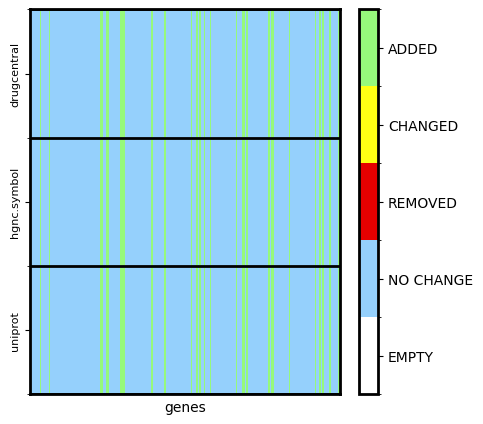

In [17]:
rename_mapping = {
    "ACCESSION": "uniprot",
    "GENE": "hgnc.symbol",
    "STRUCT_ID": "drugcentral",
}

df_annotations = pd.merge(
    df_model_mappings.loc[:, [annotation_type, mapping_key]],
    df_drugcentral.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1),
    left_on=mapping_key,
    right_on=mapping_key,
    how="left",
)
df_annotations = df_annotations.dropna().drop_duplicates()
df_annotations = df_annotations.groupby(annotation_type).agg(
    lambda x: build_string(list(x.dropna().unique()))
)
df_annotations = df_annotations.reset_index(drop=False).dropna().drop_duplicates()
df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{db_tag}.tsv",
        sep="\t",
        index=False,
    )
df_annotations